### Library import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from MLP_utils import *
from Mlp_model import MlpPokemon

### Data import

In [2]:
pokemon = pd.read_csv("data/all_pokemon_data.csv")
pokemon["Legendary Status"] = pokemon["Legendary Status"].astype(int)
pokemon = pokemon.loc[~pokemon["Name"].str.contains("-mega")]
del pokemon["National Dex #"] # redondant column
del pokemon["Height (dm)"] # redondant column
del pokemon["Weight (hg)"] # redondant column
del pokemon["Base Stat Total"] # it is just the sum of all stat, not very new
del pokemon["Name"] # delet pokemon name (not needed)
pokemon.to_csv("data/all_pokemon_filter.csv")

## Data exploration

In [3]:
pokemonNumber = pokemon.select_dtypes(include = "number")

Text(0.5, 1.0, 'Pokemon numeric attributes correlation')

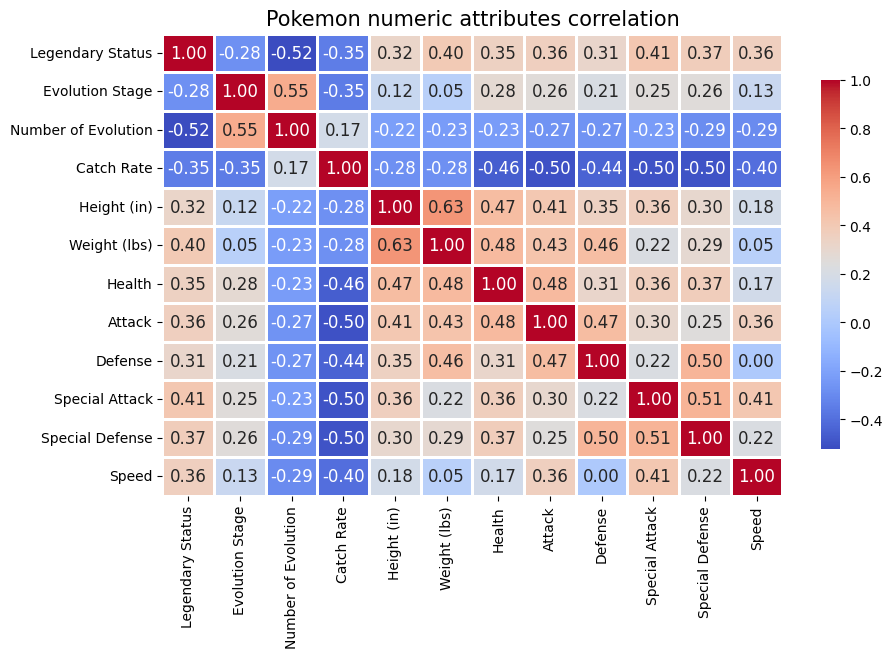

In [4]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    pokemonNumber.corr(),
    annot=True,                   # Afficher les valeurs
    cmap="coolwarm",              # Palette de couleurs alternative plus lisible
    annot_kws={"size": 12},       # Augmente la taille des annotations
    fmt=".2f",                    # Format des nombres (2 décimales)
    linewidths=1,                 # Ajoute des lignes entre les cellules
    cbar_kws={"shrink": 0.8}      # Ajuste la taille de la barre de couleur
)
plt.title("Pokemon numeric attributes correlation", size = 15)

### Loading processed data

In [5]:
# X_train is a SMOTE object
# y_train is a SMOTE object
# X_test not a SMOTE object, but cat values has been converted into numeric vectors
# y_test is inchanged
X_train, y_train, X_test, y_test, preprocessor = prepareDataForMlp(pokemon)
X_train_df = encodedDataToDataFrame(preprocessor, X_train)
X_test_df = encodedDataToDataFrame(preprocessor, X_test)

In [7]:
mlp = MlpPokemon(X_train, y_train, X_test, y_test, preprocessor)
optimisationOutput = mlp.optimizeHyperparameters(X_train, y_train, X_test, y_test, preprocessor)

Evaluation of 72 parameter combinaisons...: 100%|██████████| 72/72 [06:00<00:00,  5.01s/it]


===Best model ===
Parameters: {'hiddenDim': 64, 'learningRate': 0.01, 'batchSize': 64, 'numEpochs': 100}
Mean F-1 score: 0.9931
Mean accuracy: 0.9931


In [10]:
cvResults = optimisationOutput["bestResults"]["cvResults"]

In [12]:
optimisationOutput["bestParams"]

{'hiddenDim': 64, 'learningRate': 0.01, 'batchSize': 64, 'numEpochs': 100}

=== Cross validation results===
Accuracy: 0.9931 ± 0.0022
Precision: 0.9863 ± 0.0045
Recall: 1.0000 ± 0.0000
F1: 0.9931 ± 0.0023


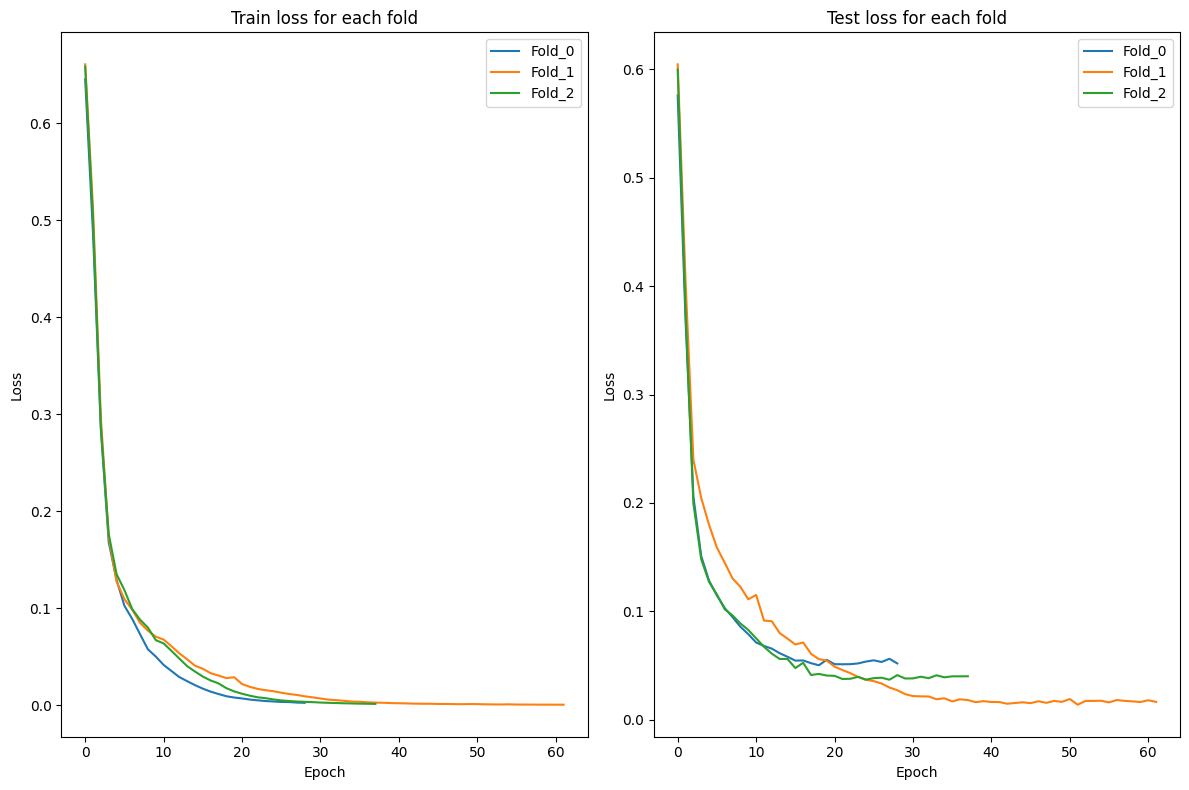

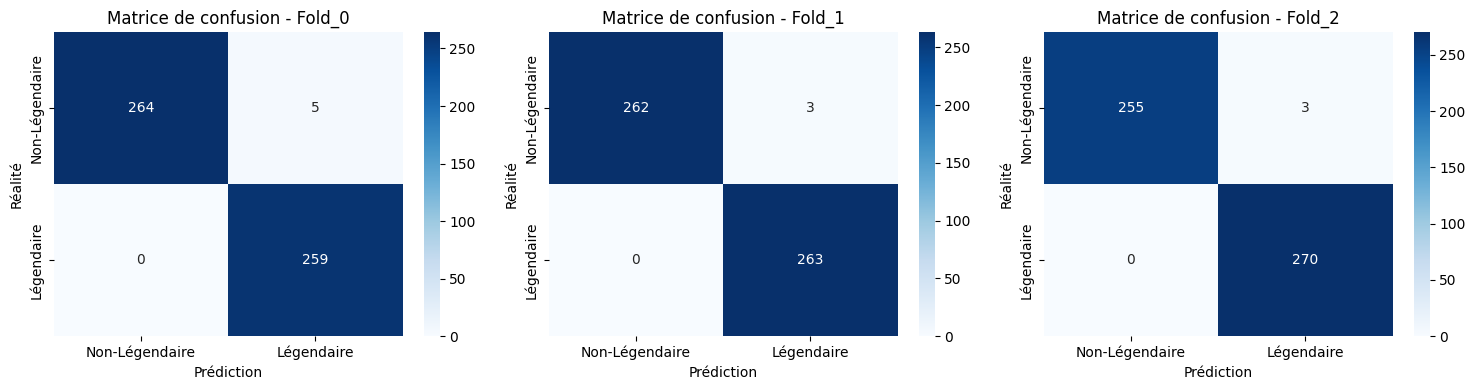

<Figure size 1000x600 with 0 Axes>

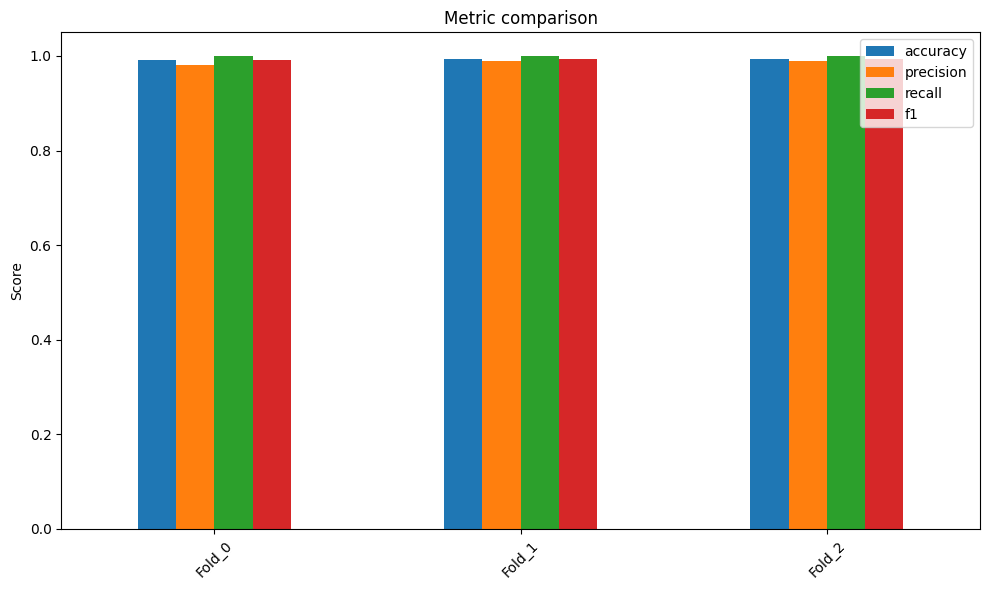

Seuil moyen: 0.7333 ± 0.0850


In [11]:
completeCvAnalysis(cvResults)

In [18]:
from torch import optim

bestParams = optimisationOutput["bestParams"]

mlp = MlpPokemon(X_train, y_train, X_test, y_test, preprocessor, hiddenDim= bestParams["hiddenDim"], batchSize= bestParams["batchSize"], numEpoch= bestParams["numEpochs"])

# Load the saved state_dict into the model
mlp.model.load_state_dict(torch.load("models/best_model.pth"))

# Ensure the model is in evaluation mode
mlp.model.eval()

# Recreate the optimizer with the model's parameters
mlp.optimiser = optim.Adam(mlp.model.parameters(), lr = bestParams['learningRate'])

In [26]:
trainLoss, testLoss, yPred = mlp.classicPredict()
bestThreshold = getBestThresholdsForF1(y_test, yPred)
yPredClass = mlp.getPredictionClass(bestThreshold)
confusion_matrix(y_test, yPredClass)

array([[191,   3],
       [  3,  31]])

In [31]:
dummyCvResults = getPerformanceStatistics(y_test, yPredClass)
dummyCvResults = {"0": dummyCvResults}
analyseCvOutput(dummyCvResults)

=== Cross validation results===
Accuracy: 0.9737 ± nan
Precision: 0.9118 ± nan
Recall: 0.9118 ± nan
F1: 0.9118 ± nan


,accuracy,precision,recall,f1
0,0.973684,0.911765,0.911765,0.911765


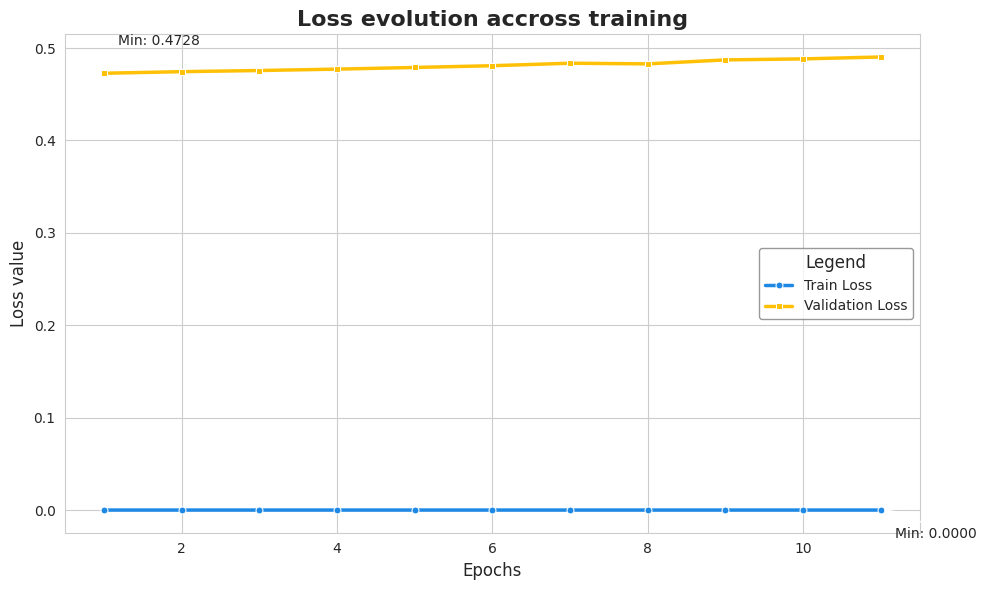

In [27]:
lossPlot(trainLoss, testLoss)

### Performance analysis

In [ ]:
dictStat = getPerformanceStatistics(y_test, yPredClass)

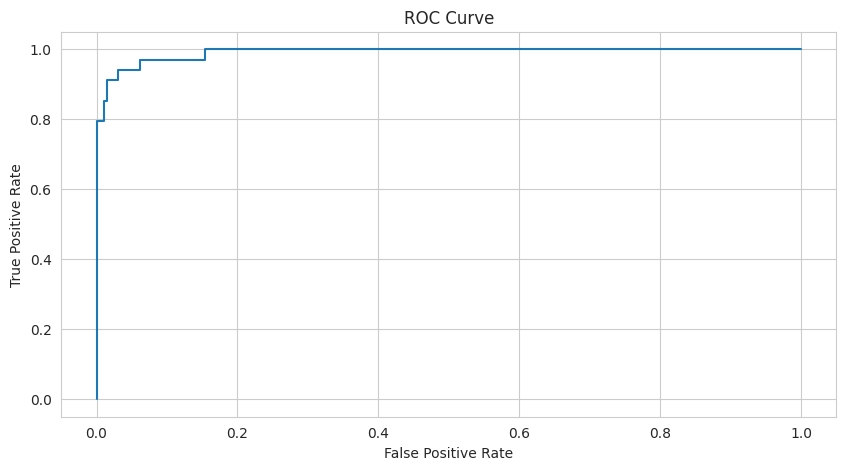

,False positive rate,True positive rate,thresholds
0,0.000000,0.000000,inf
1,0.000000,0.029412,0.999996
2,0.000000,0.794118,0.926717
3,0.010309,0.794118,0.904648
4,0.010309,0.852941,0.826607
5,0.015464,0.852941,0.814748
6,0.015464,0.911765,0.674821
7,0.030928,0.911765,0.361838
8,0.030928,0.941176,0.215836
9,0.061856,0.941176,0.096138


In [ ]:
rocCurve(y_test, yPredProba)

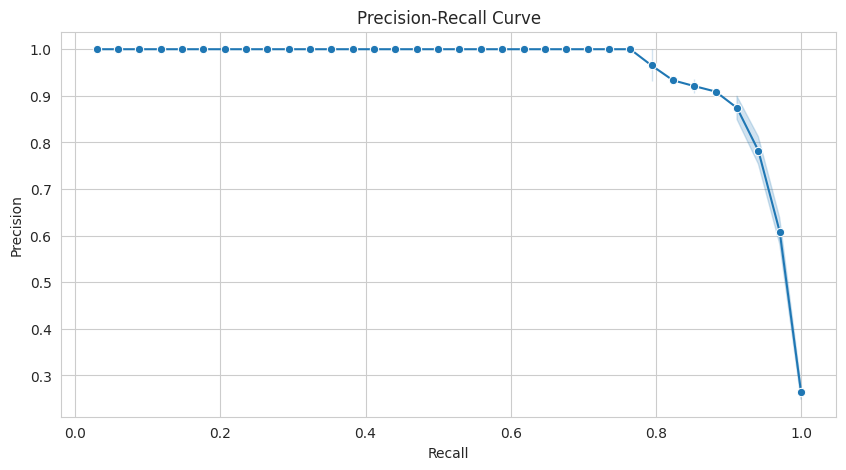

,Precision,Recall,thresholds
0,0.149123,1.000000,0.000359
1,0.149780,1.000000,0.000402
2,0.150442,1.000000,0.000449
3,0.151111,1.000000,0.000477
4,0.151786,1.000000,0.000669
...,...,...,...
221,1.000000,0.147059,0.999835
222,1.000000,0.117647,0.999926
223,1.000000,0.088235,0.999951
224,1.000000,0.058824,0.999992


In [ ]:
precisionRecallCurve(y_test, yPredProba)

In [ ]:
bestThreshold = getBestThresholdsForF1(y_test, yPredProba)
print(f"The best thresholds is {bestThreshold:.2f}")

The best thresholds is 0.45


### Processed data visualisation

- Numeric features

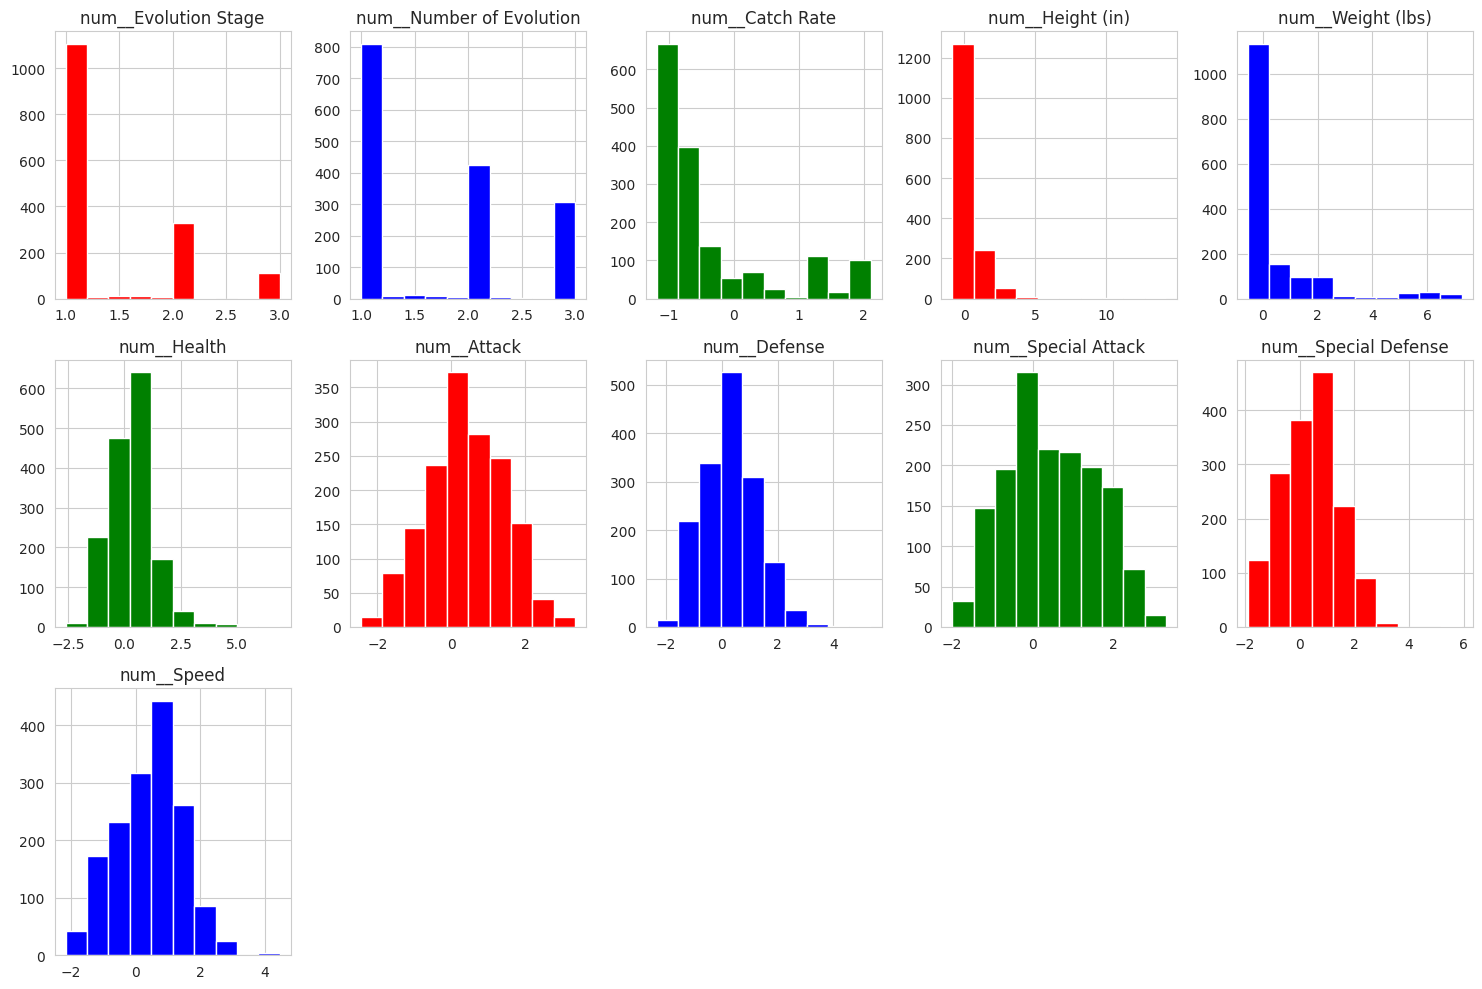

In [ ]:
numDataDistribution(X_train_df, nbPlot= 11)

- Categorical features

/home/edmond/Documents/PytorchProjects/MLP/MLP_pytorch/MLP_utils.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(catColMinimal, rotation=90)
/home/edmond/Documents/PytorchProjects/MLP/MLP_pytorch/MLP_utils.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(catColMinimal, rotation=90)
/home/edmond/Documents/PytorchProjects/MLP/MLP_pytorch/MLP_utils.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(catColMinimal, rotation=90)
/home/edmond/Documents/PytorchProjects/MLP/MLP_pytorch/MLP_utils.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(catColMinimal, rotation=90)


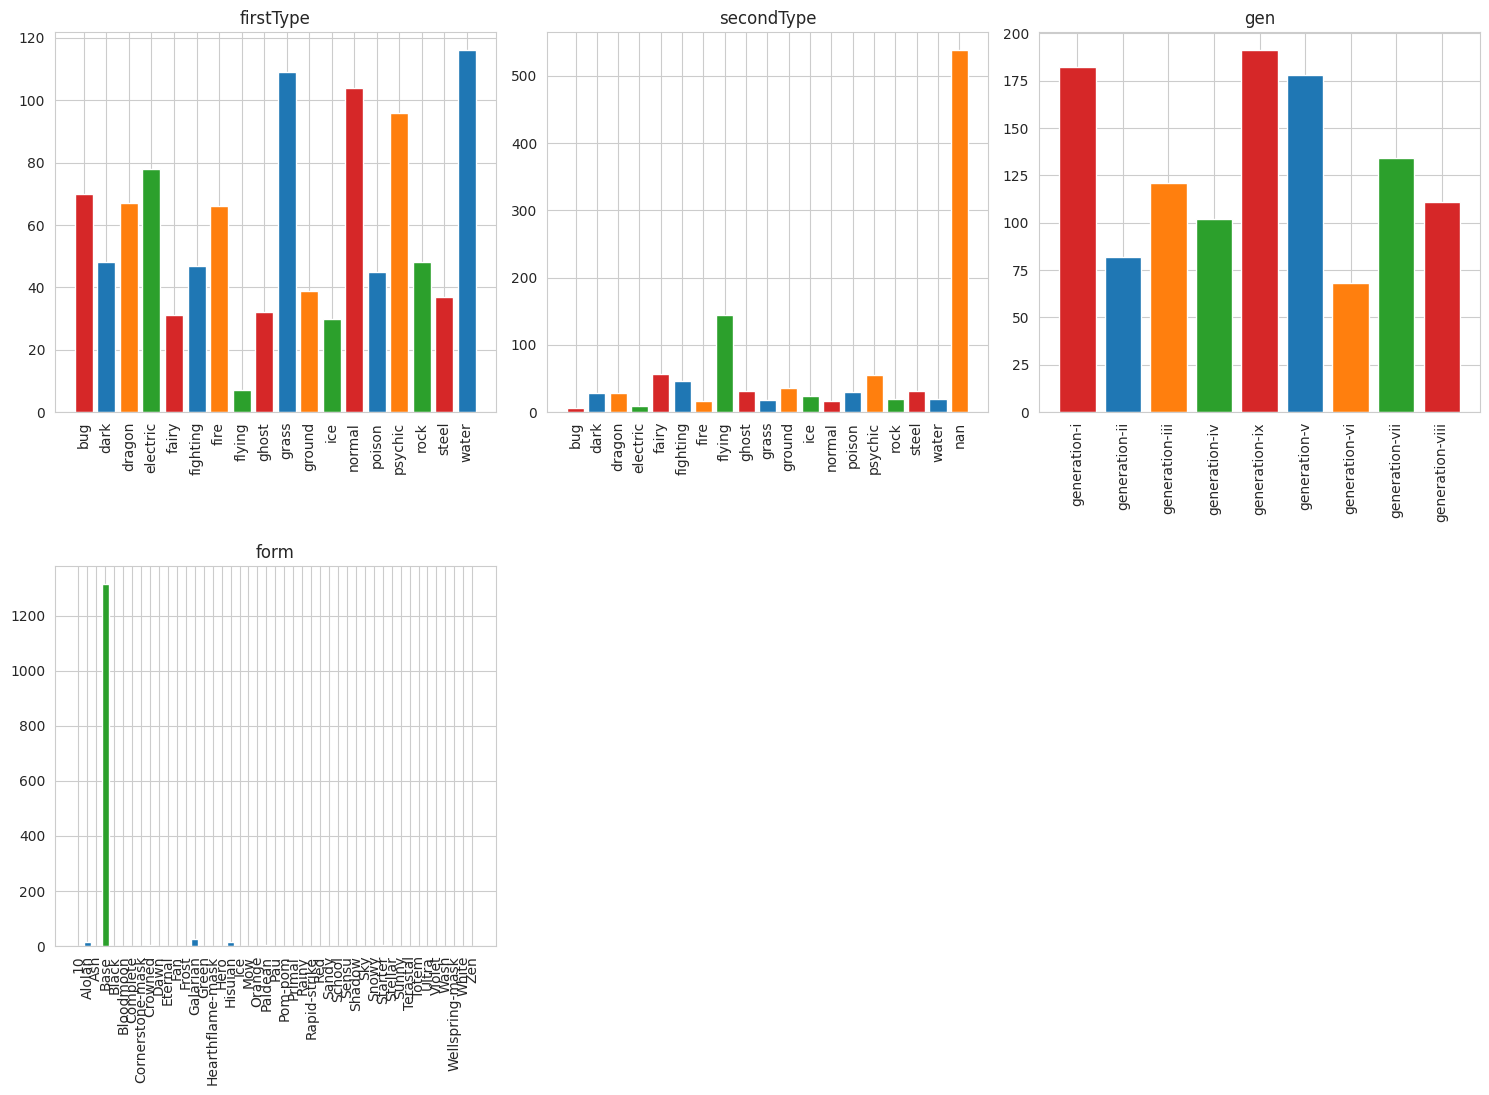

In [ ]:
multiplePlot(X_train_df)

### Prediction